# **Deep Learning Project - Pothole detection** <br/>
# **Data Exploration**
**Data Science and Advanced Analytics with a specialization in Data Science**<br/>
**NOVA IMS**<br/>
Authors of this notebook: <br/>
* Mafalda Paço (20220619@novaims.unl.pt)<br/>
* Mª Margarida Graça (20220602@novaims.unl.pt)<br/>
* Marta Dinis (20220611@novaims.unl.pt)<br/>
* Nuno Dias (20220603@novaims.unl.pt)<br/>
* Patrícia Morais (20220638@novaims.unl.pt)<br/>



## Ready to use Dataset
https://drive.google.com/file/d/1KE507iE7Hwb7TiJINnvMYCXNIGrEgPvt/view?usp=share_link



# **Summary**

In this notebook, we analysed our images and identified some problems, such as, images in different formats and color modes. We checked if our dataset was balanced and if there were duplicate images.

## **Data Import**

Necessary library imports.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import time
import shutil
import random
import zipfile

from skimage.metrics import mean_squared_error

In [ ]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/DL/Project/"
main_folder, training_folder, testing_folder = "DATA_original/", "train/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'DATA_original.zip', 'DATA_original.zip')
    # Extract files
    zip_ = zipfile.ZipFile('DATA_original.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File transfer completed in 1.756 seconds


We created this function that takes a folder path as input and processes the images to return two Numpy arrays, representing images and labels. The function assigns a label of 0 for 'Plain' images and 1 for the other category.

In [ ]:
def load_data(folder_path):
    images = []
    labels = []
    subfolders = os.listdir(folder_path)
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        label = 0 if 'Plain' in subfolder else 1
        for image_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_name)
            image = Image.open(image_path)
            images.append(np.array(image))
            labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = load_data(os.path.join(path, main_folder, training_folder))
test_images, test_labels = load_data(os.path.join(path, main_folder, testing_folder))

<ipython-input-3-86634a00e3b7>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images), np.array(labels)


Here we can see some random images of our dataset with its corresponding labels.

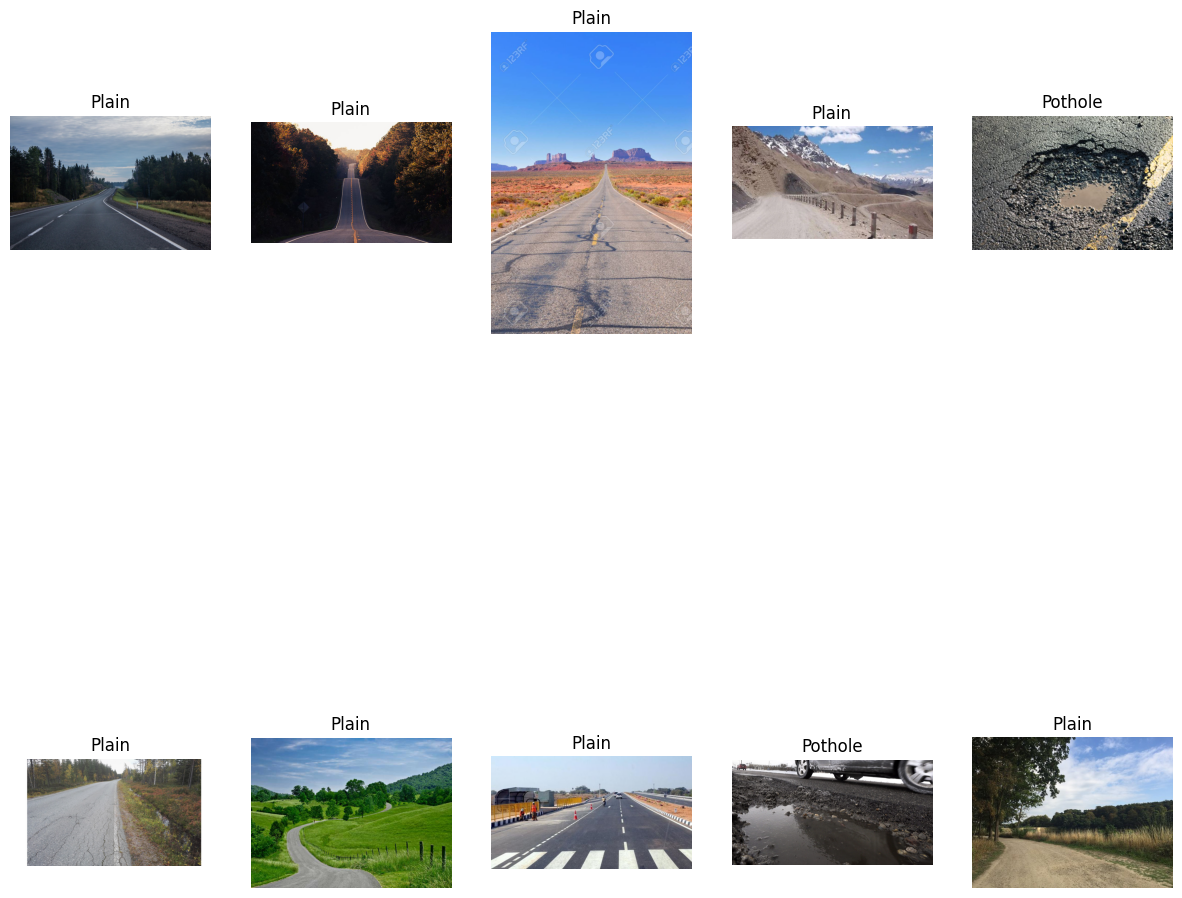

In [ ]:
# Visualize some images
fig, axes = plt.subplots(2, 5, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    index = random.randint(0, len(train_images)-1)
    ax.imshow(train_images[index])
    ax.set_title('Plain' if train_labels[index] == 0 else 'Pothole')
    ax.axis('off')
plt.show()

We can see the class distribution of our dataset both in training and test, and conclude that we have a balanced dataset.

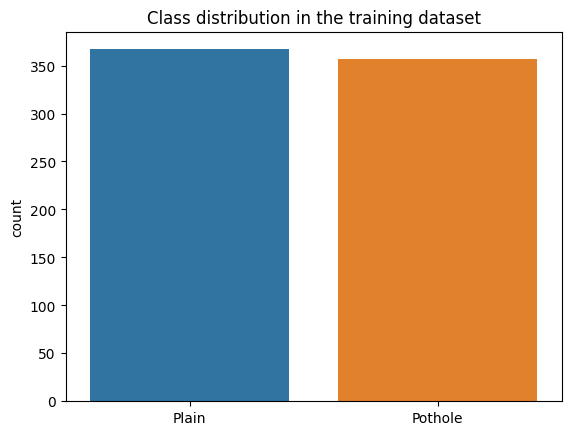

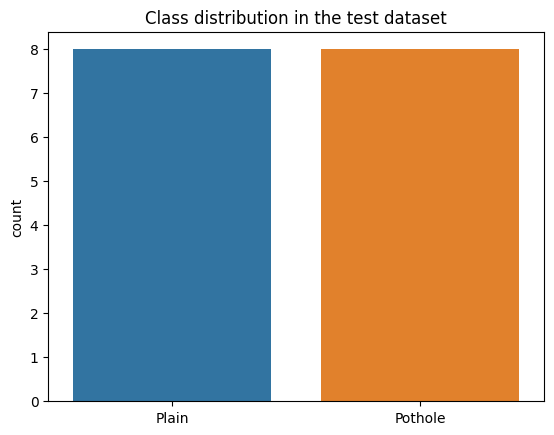

In [ ]:
# Class distribution
label_names = ["Plain", "Pothole"]
sns.countplot(x=[label_names[i] for i in train_labels])
plt.title('Class distribution in the training dataset')
plt.show()

sns.countplot(x=[label_names[i] for i in test_labels])
plt.title('Class distribution in the test dataset')
plt.show()

In image size distribution we can see that most of the images have similar sizes, but not equal, so we will need to resize them further in our work.

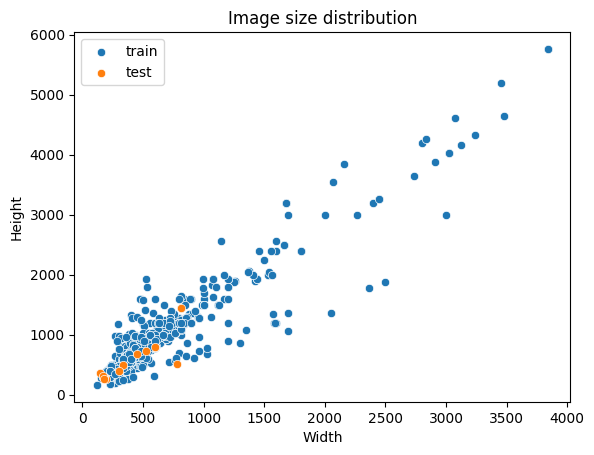

In [ ]:
# Image size distribution
train_img_sizes = [img.shape for img in train_images]
test_img_sizes = [img.shape for img in test_images]

sns.scatterplot(x=[s[0] for s in train_img_sizes], y=[s[1] for s in train_img_sizes], label='train')
sns.scatterplot(x=[s[0] for s in test_img_sizes], y=[s[1] for s in test_img_sizes], label='test')
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image size distribution')
plt.legend()
plt.show()


In [ ]:
# Dataset shapes
print(f'Training images shape: {train_images.shape[0]}')
print(f'Training labels shape: {train_labels.shape[0]}')
print(f'Testing images shape: {test_images.shape[0]}')
print(f'Testing labels shape: {test_labels.shape[0]}')

Training images shape: 724
Training labels shape: 724
Testing images shape: 16
Testing labels shape: 16


Here we can see the images formats and color modes, in our dataset, which are not ideal to work with since they have different values so we will change them in data preprocess.

In [ ]:
def get_all_image_formats(folder_path):
    formats = set()
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                ext = os.path.splitext(file)[1].lower()
                formats.add(ext)
    return formats

path = "/content/DATA_original"
image_formats = get_all_image_formats(path)

print("Image formats present in the dataset:")
for fmt in image_formats:
    print(fmt)

Image formats present in the dataset:
.png
.jpeg
.gif
.jpg


In [ ]:
def get_all_image_paths(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                image_paths.append(os.path.join(root, file))
    return image_paths

def get_image_color_modes(image_paths):
    color_modes = set()
    for image_path in image_paths:
        try:
            img = Image.open(image_path)
            color_modes.add(img.mode)
            img.close()
        except Exception as e:
            print(f"Error opening image {image_path}: {e}")
    return color_modes

path = "/content/DATA_original"
image_paths = get_all_image_paths(path)
color_modes = get_image_color_modes(image_paths)

print("Color modes present in the dataset:")
for mode in color_modes:
    print(mode)

Color modes present in the dataset:
P
RGBA
RGB


Image color distribution: The distribution of colors across the images to understand if there's any significant difference between the two classes.

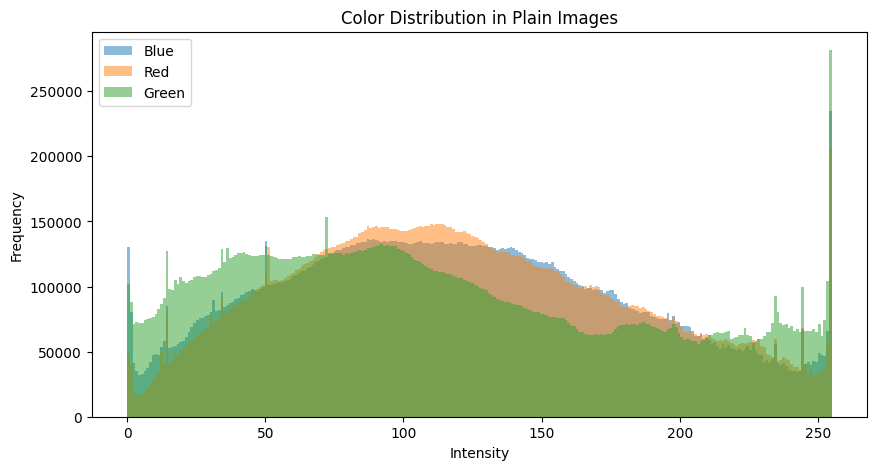

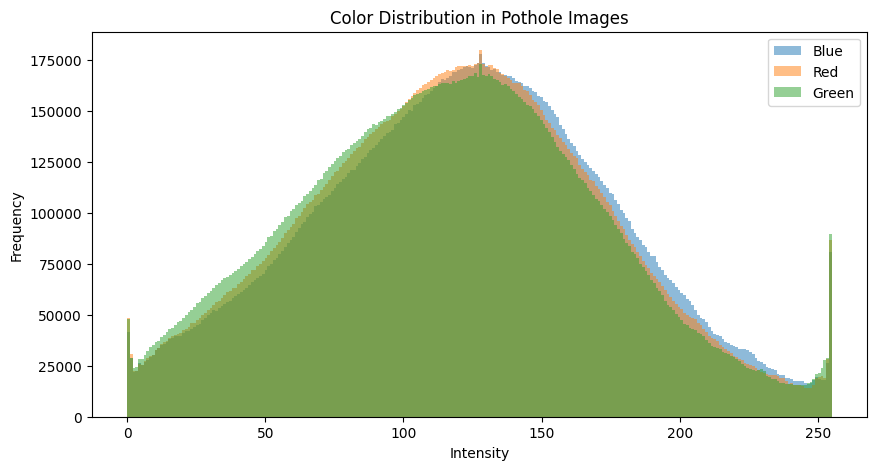

In [ ]:
from skimage.transform import resize
from skimage.color import gray2rgb

def plot_color_distribution(images, title, target_size=(256, 256)):
    resized_images = []
    for img in images:
        if len(img.shape) == 2:
            img = gray2rgb(img)
        resized_images.append(resize(img, target_size, mode='reflect', anti_aliasing=True))

    colors = ['Blue', 'Red', 'Green']
    for i, color in enumerate(colors):
        channel_data = np.concatenate([img[:, :, i] for img in resized_images]).ravel() * 255
        plt.hist(channel_data, bins=256, alpha=0.5, label=color)
    plt.legend()
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.title(title)

plain_images = train_images[train_labels == 0]
pothole_images = train_images[train_labels == 1]

plt.figure(figsize=(10, 5))
plot_color_distribution(plain_images, 'Color Distribution in Plain Images')
plt.show()

plt.figure(figsize=(10, 5))
plot_color_distribution(pothole_images, 'Color Distribution in Pothole Images')
plt.show()

In the context of the color distribution plot, the intensity corresponds to the value of a specific color channel (red, green, or blue) in an image. The intensity values range from 0 to 255 for 8-bit images, where 0 represents the lowest intensity (no color presence, e.g., black for all channels) and 255 represents the highest intensity (full color presence, e.g., red for the red channel).

In the plot, the x-axis shows the intensity values, and the y-axis represents the frequency or count of pixels with that specific intensity value. The color distribution plot gives you an idea of the overall color composition of the set of images you are analyzing. It can help you understand the brightness and color balance of the images in the dataset.

In [ ]:
def get_all_image_paths(folder):
    image_paths = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

def find_duplicates_with_mse(image_paths, mse_threshold=100, resize_shape=(256, 256)):
    duplicate_pairs = []
    images = [Image.open(path).convert("RGB").resize(resize_shape) for path in image_paths]

    for i, img1 in enumerate(images):
        for j, img2 in enumerate(images[i+1:], start=i+1):
            mse = mean_squared_error(np.array(img1), np.array(img2))
            if mse < mse_threshold:
                duplicate_pairs.append((image_paths[i], image_paths[j], mse))

    return duplicate_pairs

# Load all images from the main folder
main_folder_path = os.path.join(path, main_folder)
all_image_paths = get_all_image_paths(main_folder_path)

# Find duplicates
duplicates = find_duplicates_with_mse(all_image_paths)
print("Duplicate image pairs:")
for img1_path, img2_path, mse in duplicates:
    print(f"{img1_path} and {img2_path} (MSE: {mse})")


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Duplicate image pairs:
DATA_original/train/Plain/2.eyre-highway-AP101489089.jpg and DATA_original/train/Plain/58.eyre-highway-AP101489089.jpg (MSE: 0.0)
DATA_original/train/Plain/6.jpg and DATA_original/train/Plain/4.Essay-Roads-Featured.jpg (MSE: 0.0)
DATA_original/train/Plain/3.Ram-Country-Roads-US-FI-630x339.jpg and DATA_original/train/Plain/140.Ram-Country-Roads-US-FI-630x339.jpg (MSE: 0.0)
DATA_original/train/Plain/2.federation-way-1.jpg and DATA_original/train/Plain/284.federation-way-1.jpg (MSE: 0.0)
DATA_original/train/Pothole/65.1-18.jpg and DATA_original/train/Pothole/57.1-18.jpg (MSE: 0.0)
DATA_original/train/Pothole/263.Potholes-Road-car-770x433-1-770x433.jpg and DATA_original/train/Pothole/189.Potholes-Road-car-770x433-1-770x433.jpg (MSE: 0.0)
DATA_original/train/Pothole/23.jpg and DATA_original/train/Pothole/79.shutterstock_626273606.0.jpg (MSE: 0.50811767578125)
DATA_original/train/Pothole/4.jpg and DATA_original/train/Pothole/355.potholes-1500x1125.jpg (MSE: 17.98905436

Now we checked for duplicates in our dataset, we can see that they exist and we will remove them in data preprocess.